# Case 2 - Exploration

## 1. Importing Libraries

In [162]:
import numpy as np
import pandas as pd

# Imputers
from sklearn.impute import KNNImputer, SimpleImputer

# Standardization scalers
from sklearn.preprocessing import StandardScaler

# Splitting data
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
import random
random.seed(42)


#For clustering
# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

## 2. Loading Data

A 312x67 datamatrix. Orginally 312x68 in the csv but the first column was the index column

In [163]:
# Path to the data files
data_path = '../../case2/HR_data.csv'


# Create a pandas dataframe and use the first row as the column names
data_pd = pd.read_csv(data_path, sep=',', header=0)
#remove the first column and reorder so the non numeric columns are the first
data_pd = data_pd.iloc[:, 1:]


#Moving identufyer columns up
id_columns = ['Round', 'Phase', 'Individual','Puzzler', 'Cohort']
numeric_columns = [col for col in data_pd.columns if col not in id_columns]
data_pd = data_pd[id_columns + numeric_columns]
# 
# Print the shape of the data in the pandas dataframe
print("The shape of the data")
print(data_pd.shape)


The shape of the data
(312, 67)


## 3. Data cleaning & visualisation

### Missing values:

In [164]:
# Shows count of NaNs per column
na_summary = data_pd.isna().sum()
# Display only columns with at least 1 NaN (optional)
na_summary = na_summary[na_summary > 0]
print(na_summary)


EDA_TD_P_RT     1
EDA_TD_P_ReT    1
inspired        2
attentive       1
afraid          1
active          1
determined      2
dtype: int64


- Filling missing values in questionaries columns by impuding with the most common value for individuals in that phase
- Filling missing values in the biometric data columns with mean

In [165]:
q_cols = ['Frustrated', 'upset', 'hostile',
       'alert', 'ashamed', 'inspired', 'nervous', 'attentive', 'afraid',
       'active', 'determined']
#Filling missing values in questionaire columns 
data_pd[q_cols] = data_pd.groupby('Phase')[q_cols].transform(lambda x: x.fillna(x.mode().iloc[0]))

#Filling the missin
data_pd.fillna({col: data_pd[col].mean() for col in ['EDA_TD_P_RT', 'EDA_TD_P_ReT']}, inplace=True)

biometric_df = data_pd.iloc[:, 5:56]

emotions_df = data_pd.iloc[:, 56:-1]
emotions_df.columns

Index(['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired',
       'nervous', 'attentive', 'afraid', 'active'],
      dtype='object')

#### 3.1 Boxplots of the emotions in three phases

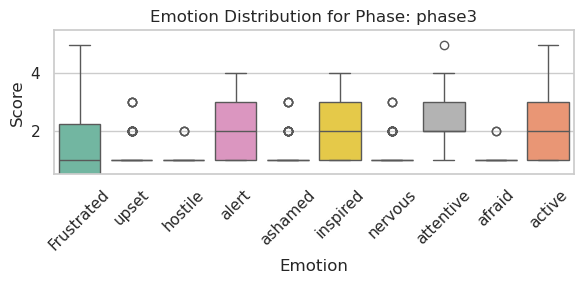

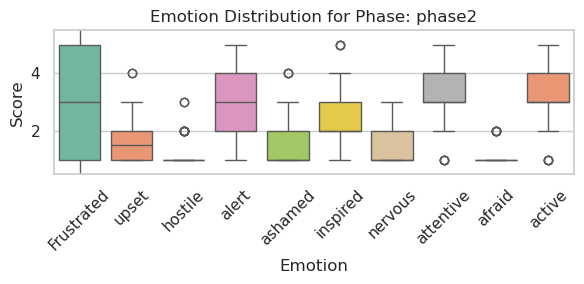

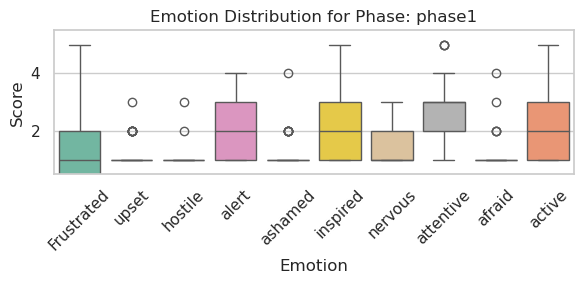

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# Emotion column names
emotion_cols = emotions_df.columns

# Define a color palette
palette = sns.color_palette("Set2", len(emotion_cols))

# Combine Phase and Emotions
full_df = data_pd[['Phase']].join(emotions_df)

# Plot one figure per phase
for phase in full_df['Phase'].unique():
    plt.figure(figsize=(6, 3))  # Smaller figure
    phase_data = full_df[full_df['Phase'] == phase]
    
    # Melt the data
    phase_data_melted = phase_data.melt(id_vars='Phase', value_vars=emotion_cols,
                                        var_name='Emotion', value_name='Score')
    
    # Correct boxplot
    sns.boxplot(x='Emotion', y='Score', hue='Emotion', data=phase_data_melted,
                palette=dict(zip(emotion_cols, palette)),
                dodge=False)  # dodge=False to keep boxes together

    plt.title(f'Emotion Distribution for Phase: {phase}')
    plt.xticks(rotation=45)
    plt.ylim(0.5, 5.5)  # Scores from 1 to 5
    plt.xlabel('Emotion')
    plt.ylabel('Score')
    plt.legend([],[], frameon=False)  # Remove legend
    plt.tight_layout()
    plt.show()

#### 3.2 Heatmap of emotions across the three phases

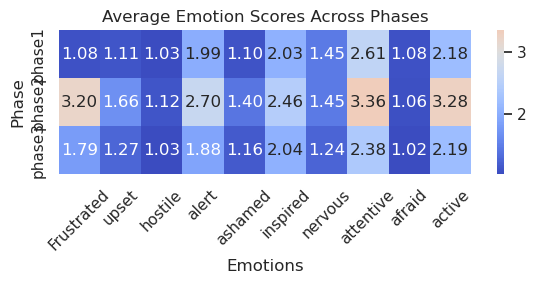

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Emotion columns
emotion_cols = emotions_df.columns

# Combine Phase and Emotions
full_df = data_pd[['Phase']].join(emotions_df)

# Group by Phase and calculate mean scores
emotion_means = full_df.groupby('Phase')[emotion_cols].mean()

# Create the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(emotion_means, annot=True, fmt=".2f", cmap="coolwarm", center=3)

plt.title('Average Emotion Scores Across Phases')
plt.xlabel('Emotions')
plt.ylabel('Phase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Explore clustering methods to derive insights from the data.

#### 4.1 Hiearchical clustering of biometric signals

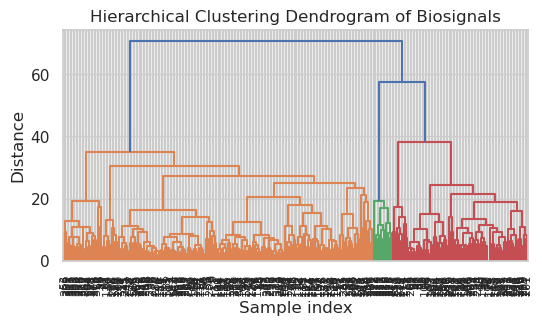

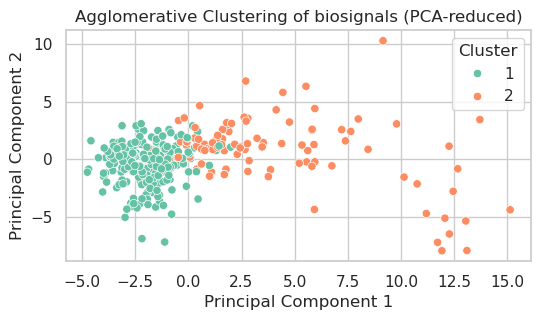

In [168]:

#Make correlation hea

# --- Standardize the biometric features ---
scaler = StandardScaler()
biometric_scaled = scaler.fit_transform(biometric_df)

# --- Perform hierarchical clustering ---
Z = linkage(biometric_scaled, method='ward', metric='euclidean')

# --- Plot the dendrogram ---
plt.figure(figsize=(6, 3))
plt.title('Hierarchical Clustering Dendrogram of Biosignals')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

# --- Optional: Cut the dendrogram to form flat clusters ---
# Here we choose to form 3 clusters (you can change 3 to another number)
cluster_labels = fcluster(Z, t=2, criterion='maxclust')

# --- Add the cluster labels back to the dataset ---
data_pd['AgglomerativeCluster'] = cluster_labels

# --- (Optional) Visualize clusters using PCA ---
pca = PCA(n_components=2)
pca_components = pca.fit_transform(biometric_scaled)

plt.figure(figsize=(6, 3))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1],
                hue=cluster_labels, palette='Set2')
plt.title('Agglomerative Clustering of biosignals (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

**Observations**: The biometric signals clusters into two to three distinct groups when visulised in PC1 and PC2

### 4.2 hiearchcal clustering of emotions

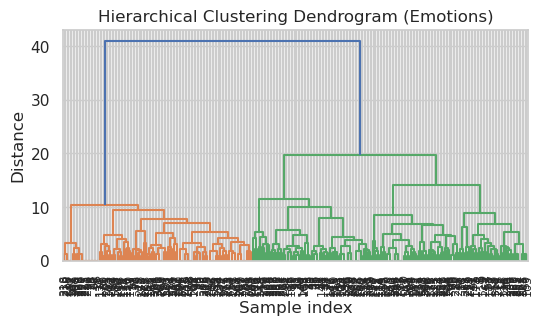

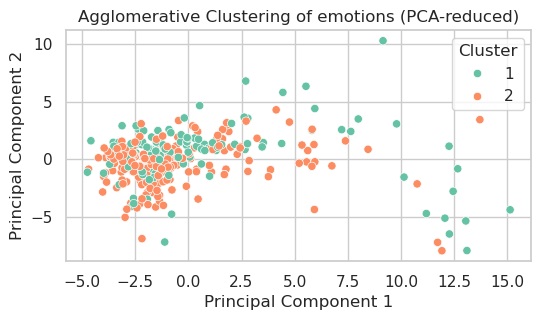

In [169]:
# --- Select only the emotion columns ---
emotion_cols = ['upset', 'hostile', 'alert', 'ashamed', 'inspired',
                'nervous', 'attentive', 'afraid', 'active', 'determined']

emotion_df = data_pd[emotion_cols]

# --- Handle missing values ---
# Drop rows with missing emotion responses
emotion_df = emotion_df.dropna()

# --- Perform hierarchical clustering ---
Z_emotions = linkage(emotion_df, method='ward', metric='euclidean')

# --- Plot the dendrogram ---
plt.figure(figsize=(6, 3))
plt.title('Hierarchical Clustering Dendrogram (Emotions)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(Z_emotions, leaf_rotation=90., leaf_font_size=8.)
plt.show()

# --- Optional: Cut the dendrogram to form flat clusters ---
# Here we choose to form 3 clusters (you can change 3 to another number)
cluster_labels = fcluster(Z_emotions, t=2, criterion='maxclust')

# --- Add the cluster labels back to the dataset ---
data_pd['AgglomerativeCluster_emotions'] = cluster_labels


# --- (Optional) Visualize clusters using PCA ---
pca = PCA(n_components=2)
pca_components = pca.fit_transform(biometric_scaled)

plt.figure(figsize=(6, 3))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1],
                hue=cluster_labels, palette='Set2')
plt.title('Agglomerative Clustering of emotions (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### 4.3 K-means

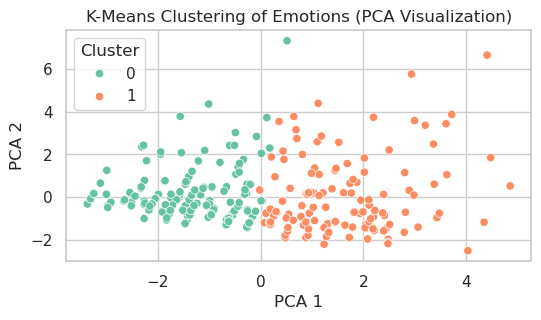

In [170]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Select emotion columns ---
emotion_cols = ['upset', 'hostile', 'alert', 'ashamed', 'inspired',
                'nervous', 'attentive', 'afraid', 'active', 'determined', 'Frustrated']

emotion_df = data_pd[emotion_cols].dropna()

# --- Step 2: Scale the emotions ---
scaler = StandardScaler()
emotion_scaled = scaler.fit_transform(emotion_df)

# --- Step 3: Run KMeans ---
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(emotion_scaled)

# --- Step 4: Add cluster labels back ---
emotion_df['EmotionCluster'] = clusters

# --- Step 5: Visualize clusters with PCA ---
pca = PCA(n_components=2)
components = pca.fit_transform(emotion_scaled)

plt.figure(figsize=(6,3))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=clusters, palette='Set2')
plt.title('K-Means Clustering of Emotions (PCA Visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

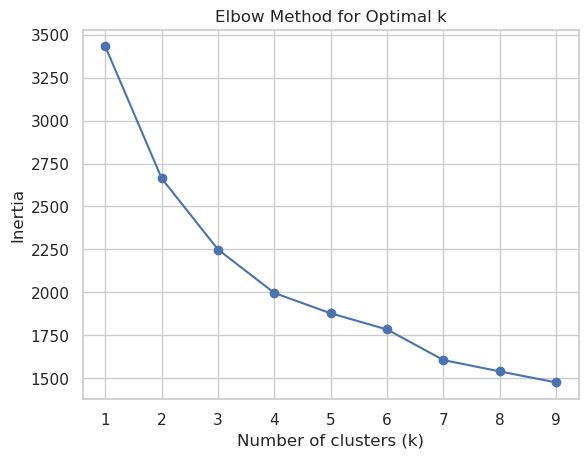

In [171]:
inertias = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(emotion_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


## 5. Dimensionality reduction

### 5.1 PCA and legend defined by cohort and phase

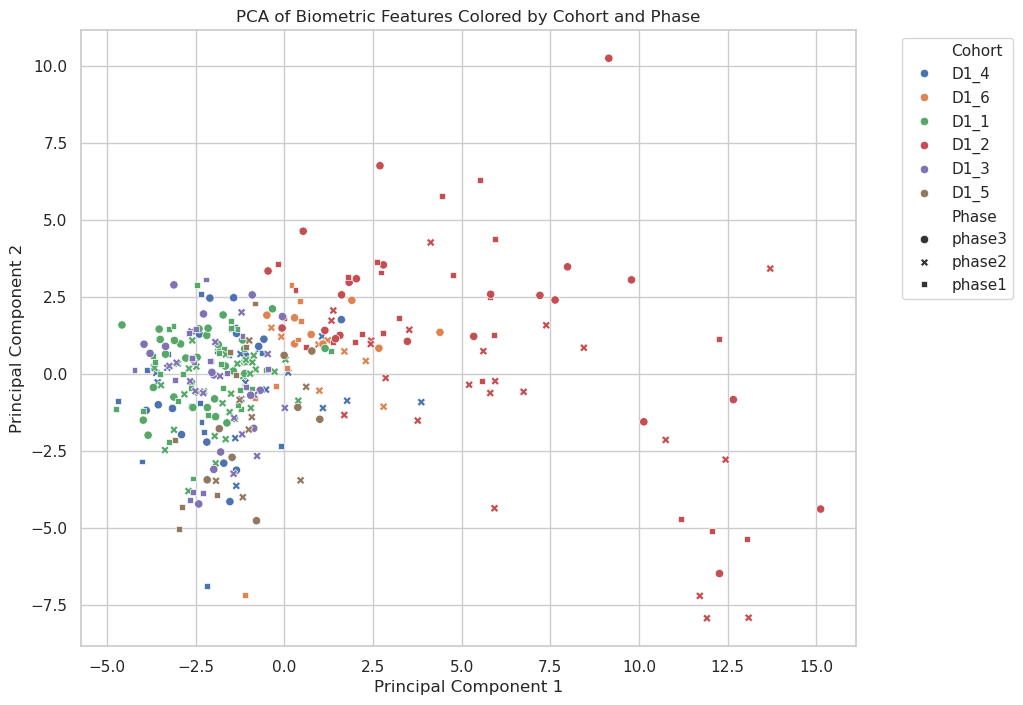

In [172]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Standardize the biometric features
scaler = StandardScaler()
biometric_scaled = scaler.fit_transform(biometric_df)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_components = pca.fit_transform(biometric_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cohort'] = data_pd['Cohort']  # add cohort info for coloring
pca_df['Phase'] = data_pd['Phase']

# Plot
plt.figure(figsize=(10,8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cohort', style='Phase')
plt.title('PCA of Biometric Features Colored by Cohort and Phase')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



In [173]:


# Combine features and target
df = data_pd.copy()
df['y'] = y

# Separate majority and minority
df_major = df[df['y'] == 1]
df_minor = df[df['y'] == 0]

# Downsample majority
df_major_downsampled = resample(df_major, replace=False, n_samples=len(df_minor), random_state=42)

# Combine
df_balanced = pd.concat([df_major_downsampled, df_minor])
X_bal = df_balanced[biometric_features]
y_bal = df_balanced['y']


# --- Step 4: Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_bal = scaler.fit_transform(X_bal)

# --- Step 5: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled_bal, y_bal, test_size=0.3, random_state=42)

# --- Step 6: Train SVM ---
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train, y_train)

# --- Step 7: Evaluate model ---
y_pred = svm.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")

ValueError: Cannot sample 159 out of arrays with dim 153 when replace is False

**Oberservations**: It seems like the D1_2 cohort is not the in the same cluster as the other cohorts. THe D1_2 cohort was conducted in the fall in one session

### 5.2 Non Negative matrix facorization **NMF**


#### 5.2.1 NMF on emotion data

In [180]:
emotion_cols = ['upset', 'hostile', 'alert', 'ashamed', 'inspired',
                'nervous', 'attentive', 'afraid', 'active', 'determined']
emotion_data = data_pd[emotion_cols]

In [181]:
from sklearn.decomposition import NMF

# Choose number of components (how many "emotion profiles" you want)
n_components = 2

# Create NMF model
nmf_model = NMF(n_components=n_components, init='random', random_state=42)

# Fit and transform
W = nmf_model.fit_transform(emotion_data)
H = nmf_model.components_


/home/aws/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


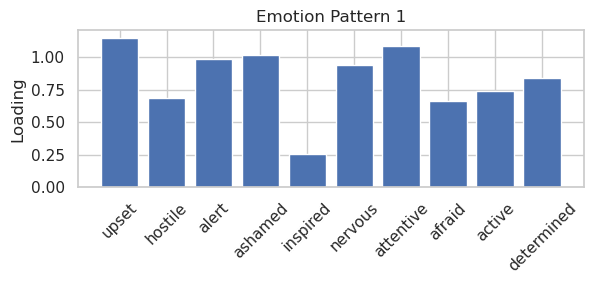

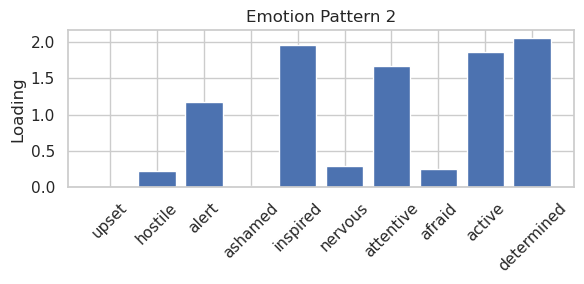

In [182]:
import matplotlib.pyplot as plt

# Plot component loadings
for i, component in enumerate(H):
    plt.figure(figsize=(6, 3))
    plt.bar(emotion_cols, component)
    plt.title(f'Emotion Pattern {i+1}')
    plt.xticks(rotation=45)
    plt.ylabel('Loading')
    plt.tight_layout()
    plt.show()


In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# W and H matrices after NMF
W_df = pd.DataFrame(W, columns=[f'Pattern_{i+1}' for i in range(W.shape[1])])
H_df = pd.DataFrame(H, columns=emotion_cols, index=[f'Pattern_{i+1}' for i in range(H.shape[0])])

# Heatmap of H (Emotion Loadings)
#plt.figure(figsize=(10, 6))
#sns.heatmap(H_df, annot=True, cmap='viridis')
#plt.title('Emotion Loadings (H matrix)')
#plt.xlabel('Emotion')
#plt.ylabel('Pattern')
#plt.show()
#
## (Optional) Heatmap of W (Participant Scores)
## Select a sample if you have too many participants
#plt.figure(figsize=(6, 3))
#sns.heatmap(W_df.iloc[:50], cmap='coolwarm')
#plt.title('Participant Pattern Scores (W matrix)')
#plt.xlabel('Pattern')
#plt.ylabel('Participant')
#plt.show()


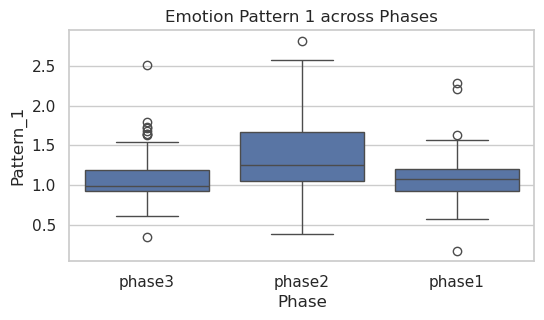

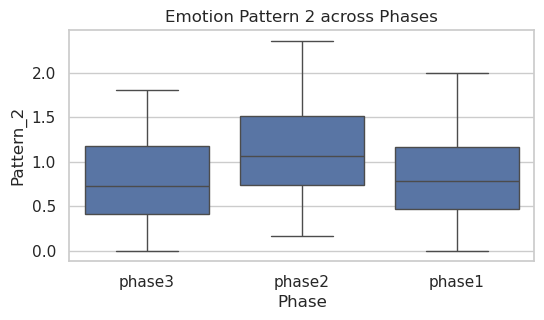

In [185]:
# Turn W matrix into a DataFrame
W_df = pd.DataFrame(W, columns=['Pattern_1', 'Pattern_2'])

# Join with original data to bring in 'Phase'
W_df['Phase'] = data_pd['Phase'].values

import seaborn as sns
import matplotlib.pyplot as plt

# Plot Pattern 1
plt.figure(figsize=(6, 3))
sns.boxplot(x='Phase', y='Pattern_1', data=W_df)
plt.title('Emotion Pattern 1 across Phases')
plt.show()

# Plot Pattern 2
plt.figure(figsize=(6, 3))
sns.boxplot(x='Phase', y='Pattern_2', data=W_df)
plt.title('Emotion Pattern 2 across Phases')
plt.show()


In [186]:
from scipy.stats import f_oneway

# One-way ANOVA for Pattern 1
groups = [group['Pattern_1'] for name, group in W_df.groupby('Phase')]
f_stat, p_val = f_oneway(*groups)
print(f'Pattern 1 ANOVA: F={f_stat:.2f}, p={p_val:.4f}')


Pattern 1 ANOVA: F=18.83, p=0.0000


**Conconclusion**:
Using NMF, we extracted two distinct emotional patterns. ANOVA results show that Pattern 1 scores differ significantly across phases, particularly in the active phase.
This suggests that Pattern 1 may represent a low-dimensional emotional state characteristic of the active phase, capturing a dominant affective profile during that period. 

## 6. Supervised 

This supervised versions encodes individuals with a y = 1 or 0 classifier according to the overall score of the postive and negative emotioons on the queationarie

- y = 1 if the mean of the postive emotions is greater than that of the negative emotions
- y = 0 vice versa

### 6.1 Model using a svm

In [ ]:


# Combine features and target
df = data_pd.copy()
df['y'] = y

# Separate majority and minority
df_major = df[df['y'] == 1]
df_minor = df[df['y'] == 0]

# Downsample majority
df_major_downsampled = resample(df_major, replace=False, n_samples=len(df_minor), random_state=42)

# Combine
df_balanced = pd.concat([df_major_downsampled, df_minor])
X_bal = df_balanced[biometric_features]
y_bal = df_balanced['y']


# --- Step 4: Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_bal = scaler.fit_transform(X_bal)

# --- Step 5: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled_bal, y_bal, test_size=0.3, random_state=42)

# --- Step 6: Train SVM ---
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train, y_train)

# --- Step 7: Evaluate model ---
y_pred = svm.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")

Confusion Matrix:
[[4 3]
 [5 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.57      0.50         7
           1       0.62      0.50      0.56        10

    accuracy                           0.53        17
   macro avg       0.53      0.54      0.53        17
weighted avg       0.55      0.53      0.53        17


Accuracy: 0.53


### 6.2 Model using a Logistic regression with L2 penalty

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assume X and y are already prepared
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train logistic regression with regularization
logreg = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")


Confusion Matrix:
[[ 7  8]
 [15 64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.47      0.38        15
           1       0.89      0.81      0.85        79

    accuracy                           0.76        94
   macro avg       0.60      0.64      0.61        94
weighted avg       0.80      0.76      0.77        94


Accuracy: 0.76
